# 1.1. Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.\
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.\
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.\
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

# 1.2. Инструкция по выполнению проекта

Загрузите и подготовьте данные. Поясните порядок действий.\
Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.\
Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.\
Проведите финальное тестирование.

# 1.3. Описание данных

Данные находятся в файле Churn.csv (англ. «отток клиентов»).
Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

# 2. Подготовка данных 

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [119]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [120]:
df.columns = [x.lower() for x in df.columns]

In [121]:
df.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [123]:
# Посмотрим распределение гистограмм для каждого количественного столбца

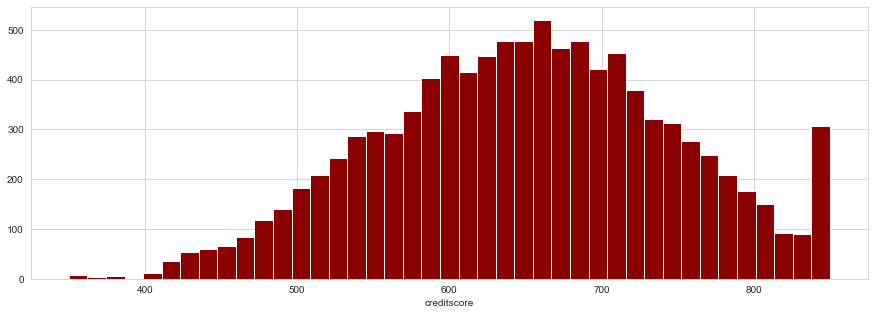

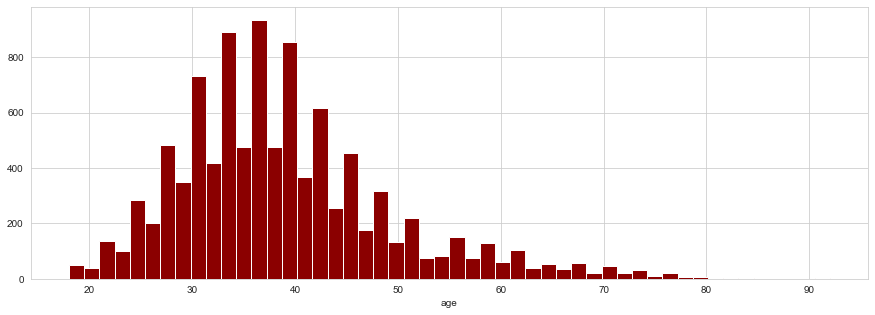

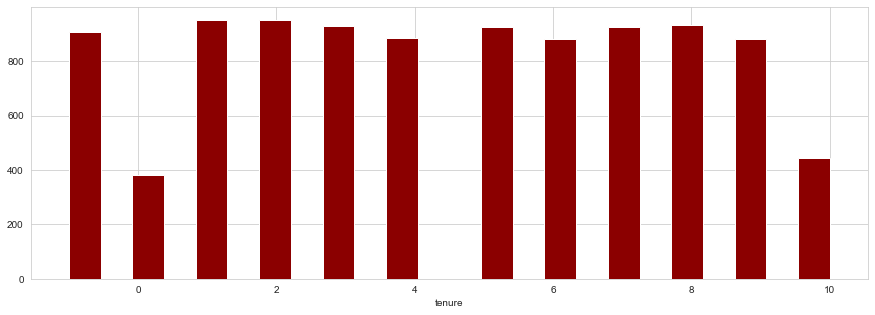

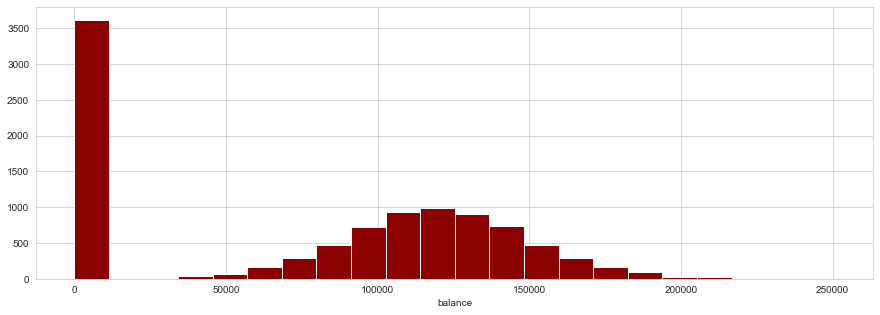

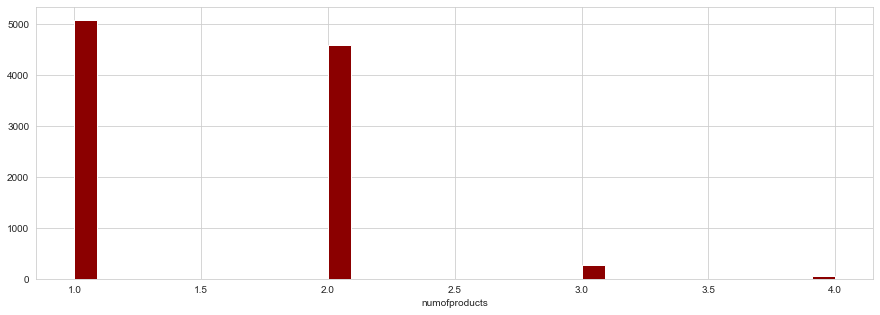

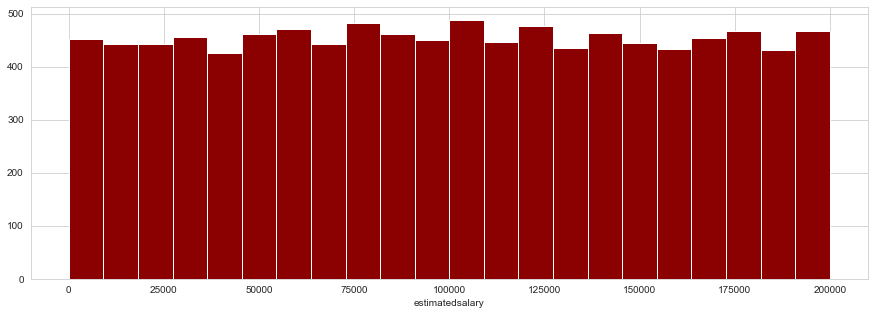

In [171]:
num_cols = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
for i, col in enumerate(num_cols):
    plt.figure(figsize=(15, 5))
    sns.distplot(df[col], kde=False, hist_kws={'alpha':1}, color='darkred')


Мы видим, что распределение зарплат (estimatedsalary) и наличия недвижимости (tenure) -> плюс-минус ровное.\
Отбросим колонки rownymber, customerid, surname, т.к. они никак не помогут нам в построении моделей. 

In [133]:
df.drop(['rownumber','customerid','surname'],axis=1,inplace=True)

In [134]:
df

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [135]:
df.query('tenure.isna()', engine='python').describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


In [136]:
df.query('tenure.isna()',engine='python').geography.value_counts()

France     464
Spain      229
Germany    216
Name: geography, dtype: int64

Мы проверили, зависят ли пропуски в недвижимости от портрета клиента (возраст, пол, другие факторы) или от страны проживания и пришли к выводу, что данные не зависят от этих факторов, соответственно, можем смело заполнять отсутствующие данные либо 0, либо -1. \
Мы заполним -1 для отличия. 

In [137]:
df.tenure = df.tenure.fillna(-1)

In [138]:
df

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


# 3. Исследование данных

In [139]:
print('Баланс классов: ', df.exited.value_counts()/len(df)) #наблюдается сильный дисбаланс классов

Баланс классов:  0    0.7963
1    0.2037
Name: exited, dtype: float64


In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [141]:
cat = ['geography', 'gender']
df.nunique().loc[cat] 

geography    3
gender       2
dtype: int64

In [142]:
# т.к. уникальных значений не так много, можем воспользоваться либо OrdinalEncoder, либо One-hot Encoder

In [143]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

In [144]:
X = df_ordinal.drop('exited',axis=1)
y = df_ordinal['exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [145]:
%%time

dtree = DecisionTreeClassifier(max_depth=5, random_state=101)
dtree.fit(X_train, y_train)
prediction = dtree.predict(X_test)
print('Train accuracy score (dtree): ', accuracy_score(y_test, prediction))
print('f1_score (dtree): ', f1_score(y_test, prediction))

Train accuracy score (dtree):  0.855
f1_score (dtree):  0.5406546990496304
CPU times: user 22.5 ms, sys: 3.54 ms, total: 26.1 ms
Wall time: 25.2 ms


In [146]:
%%time

forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=101)
forest.fit(X_train, y_train)
prediction = forest.predict(X_test)
print('Train accuracy score (forest): ', accuracy_score(y_test, prediction))
print('f1_score (forest): ', f1_score(y_test, prediction))

Train accuracy score (forest):  0.841
f1_score (forest):  0.4259927797833935
CPU times: user 85.9 ms, sys: 6.3 ms, total: 92.2 ms
Wall time: 111 ms


Т.о. мы исследовали баланс классов;
Мы видим, что выборка несбалансированна (80% - класс "0" (действующие пользователи), 20% - класс "1" (отток);\
Далее, мы применили порядковое кодирование (Ordinal Encoding) для преобразования категориальных признаков в числовые. \
Т.к. ordinal encoding не подходит для логистической регрессии, построим модели решающего дерева и случайного леса. 
Т.к. в нашем датасете наблюдается дисбаланс классов, и низкая f1 мера, попробуем построить модели с учетом дисбаланса.

In [147]:
from sklearn.utils import shuffle #перемешаем данные, чтобы наши модельки работали лучше

In [148]:
%%time 

dtree = DecisionTreeClassifier(max_depth=5, random_state=101, class_weight = 'balanced')
dtree.fit(X_train, y_train)
prediction = dtree.predict(X_test)
print('Train accuracy score (dtree): ', accuracy_score(y_test, prediction))
print('f1_score (dtree): ', f1_score(y_test, prediction))

Train accuracy score (dtree):  0.768
f1_score (dtree):  0.573529411764706
CPU times: user 24.8 ms, sys: 2.63 ms, total: 27.4 ms
Wall time: 29.8 ms


In [149]:
%%time

forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=101, class_weight='balanced')
forest.fit(X_train, y_train)
prediction = forest.predict(X_test)
print('Train accuracy score (forest): ', accuracy_score(y_test, prediction))
print('f1_score (forest): ', f1_score(y_test, prediction))

Train accuracy score (forest):  0.785
f1_score (forest):  0.5836023240800516
CPU times: user 67.3 ms, sys: 3.56 ms, total: 70.8 ms
Wall time: 73.9 ms


In [150]:
# найдем лучшие гиперпараметры с помощью GridSearchCV
from sklearn.model_selection import GridSearchCV
forest_gs = GridSearchCV(RandomForestClassifier(n_estimators=30, random_state=0),
                         param_grid={'max_depth': range(5, 31, 2),
                                    'min_samples_leaf': range(2, 5),
                                    'min_samples_split': range(2, 5),
                                    'criterion': ['gini', 'entropy']}, cv=4, refit='f1')

In [151]:
%%time
forest_gs.fit(X_train, y_train)

CPU times: user 2min 54s, sys: 2.5 s, total: 2min 57s
Wall time: 2min 59s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=None,
                                              oob_score=False, random_state=0,
                                    

In [152]:
forest_gs.best_score_

0.8574285714285715

In [153]:
forest = forest_gs.best_estimator_
forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [154]:
from sklearn.metrics import roc_auc_score, roc_curve

Text(0, 0.5, 'TPR')

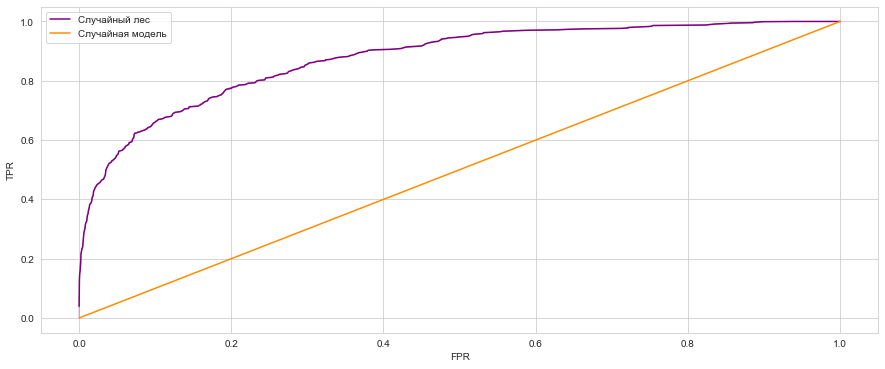

In [155]:
forest_proba = forest.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, forest_proba)

sns.set_style('whitegrid')
plt.figure(figsize=(15,6))
sns.lineplot(fpr, tpr, label='Случайный лес', color='purple')
sns.lineplot([0, 1], [0, 1], label='Случайная модель', color='darkorange')
plt.xlabel('FPR')
plt.ylabel('TPR')

Вероятно, что если немного увеличить полноту и снизить точность, то f1-мера должна остаться на месте. 

In [156]:
# теперь попробуем подобрать лучшие гиперпараметры через функцию
results = []
for estimators in range (10,60,10):
    for depth in range(3,15,1):
        forest = RandomForestClassifier(n_estimators=estimators, max_depth=depth, class_weight='balanced', random_state=101)
        forest.fit(X_train, y_train)
        prediction = forest.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        f1score = f1_score(y_test, prediction)
        results.append([estimators, depth, accuracy, f1score])

In [157]:
results = pd.DataFrame(results, columns = ['estimators', 'depth', 'f1_score', 'accuracy_score'])
results.head()

,estimators,depth,f1_score,accuracy_score
0,10,3,0.789000,0.584918
1,10,4,0.771000,0.571963
2,10,5,0.785000,0.583602
3,10,6,0.785667,0.583279
4,10,7,0.783000,0.579729


In [158]:
best_models = results.sort_values(by = 'f1_score', ascending=False).head().reset_index(drop=True)
print('Лучшие модели по f1 score: ')
print(best_models)

Лучшие модели по f1 score: 
   estimators  depth  f1_score  accuracy_score
0          30     14  0.860333        0.616651
1          50     14  0.860000        0.609665
2          50     13  0.858000        0.624339
3          40     14  0.856667        0.600372
4          20     12  0.856667        0.636210


In [159]:
forest = RandomForestClassifier(n_estimators=30, max_depth=14, class_weight='balanced', random_state=101)
forest.fit(X_train, y_train)
prediction = forest.predict(X_test)
print(f1_score(y_test, prediction))
print(accuracy_score(y_test, prediction))

0.6166514181152791
0.8603333333333333


Теперь попробуем устранить дисбаланс классов с помощью downsampling & upsampling

In [160]:
X = df_ordinal.drop('exited',axis=1)
y = df_ordinal['exited']
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=101)
    
    return X_upsampled, y_upsampled

In [161]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

print("Баланс классов после upsampling: ")
print(y_upsampled.value_counts()/len(y_upsampled))

Баланс классов после upsampling: 
1.0    0.503335
0.0    0.496665
Name: exited, dtype: float64


In [162]:
def downsample (X,y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_downsampled = pd.concat([X_zeros.sample(frac = fraction, random_state=101)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=101)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=101)
    
    return X_downsampled, y_downsampled

In [163]:
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)
print("Баланс классов после downsampling:")
print(y_downsampled.value_counts()/len(y_downsampled))

Баланс классов после downsampling:
1.0    0.50338
0.0    0.49662
Name: exited, dtype: float64


In [164]:
results = [] 

for estimators in range(10, 110, 10): 
    for depth in range(3, 20, 1):
        forest = RandomForestClassifier(n_estimators=estimators, max_depth=depth, class_weight='balanced', random_state=12345) 
        forest.fit(X_upsampled, y_upsampled)
        prediction = forest.predict(X_test)
        f1score = f1_score(y_test, prediction)
        accuracy = accuracy_score(y_test, prediction)
        results.append([estimators, depth, f1score, accuracy])

results = pd.DataFrame(results, columns = ['estimators', 'depth', 'f1_score', 'accuracy'])

In [165]:
print("Лучшие модели по F1-метрике (upsampling): ")
print(results.sort_values(by='f1_score', ascending=False).head()) 

Лучшие модели по F1-метрике (upsampling): 
     estimators  depth  f1_score  accuracy
164         100     14  0.638095  0.848000
80           50     15  0.637037  0.853000
79           50     14  0.636656  0.849333
130          80     14  0.636291  0.848333
96           60     14  0.635634  0.848667


In [166]:
results = []

for estimators in range(10,105,10):
    for depth in range(3,20,1):
        forest = RandomForestClassifier(n_estimators=estimators, max_depth=depth, class_weight='balanced', random_state=101)
        forest.fit(X_downsampled, y_downsampled)
        prediction = forest.predict(X_test)
        f1score = f1_score(y_test, prediction)
        accuracy = accuracy_score(y_test, prediction)
        results.append([estimators, depth, f1score, accuracy])
        
results = pd.DataFrame(results, columns = ['estimators','depth','f1 score','accuracy'])

In [167]:
print("Лучшие модели по F1-метрике (downsampling): ")
print(results.sort_values(by='f1 score', ascending=False).head()) 

Лучшие модели по F1-метрике (downsampling): 
     estimators  depth  f1 score  accuracy
114          70     15  0.603558  0.792000
165         100     15  0.603558  0.792000
148          90     15  0.603295  0.791333
40           30      9  0.603215  0.794333
57           40      9  0.602317  0.794000


Для того, чтобы устранить дисбаланс нами были предприняты следующие действия: 

1) была произведена автокоррекция весов классов (class_weight='balanced' в RandomForest);\
2) также мы изменили train sample с помощью методов даунсэмплинга и апсемплинга;\
3) Вычислили accuracy(точность) и F1-метрику для моделей с различными параметрами n_estimators (от 10 до 105 с шагом 10) , а также max_depth (от 3 до 20 с шагом 1) .

После проведенного исследования, мы обнаружили, что максимальные значения метрики f1-score достигается у модели RandomForest с автокоррекцией веса (class_weight='balanced'), со значениями n_estimators = 30, max_depth = 14

# 4. Финальное тестирование данных

In [168]:
from sklearn.metrics import roc_auc_score, roc_curve

0.8641235711059849


<function matplotlib.pyplot.show(*args, **kw)>

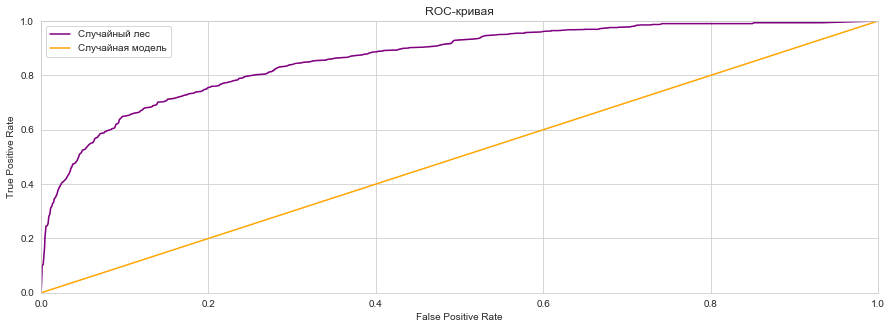

In [170]:
forest = RandomForestClassifier(n_estimators=30, max_depth=14, class_weight = 'balanced', random_state=101)
forest.fit(X_train, y_train)
prediction = forest.predict(X_test)
probabilities_test = forest.predict_proba(X_test)
probabilities_one_test = probabilities_test[:,1]

roc_auc = roc_auc_score(y_test, probabilities_one_test)
print(roc_auc)

fpr,tpr,thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure(figsize=(15,5))
sns.lineplot(fpr,tpr,label='Случайный лес', color='purple')
#ROC-кривая случайной модели(выглядит как прямая)
sns.lineplot([0,1],[0,1],linestyle='--',color='orange', label='Случайная модель' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show


In [ ]:
print('F1-score на тестовой выборке: ', f1_score(forest.predict(X_test),y_test)) 

- Таким образом, мера f1-score конечной модели = ~0.617, соответственно, условие задачи (довести метрику до 0.59) выполняется.  выполняется условие задания. 

- Мы также построили ROC-кривую, вычислили AUC-ROC(0.864), и т.к. для случайной модели значение ROC-AUC составляет 0,5, а у нашей модели этот результат гораздо выше - можно говорить о том, что наша модель отличается от случайной и является адекватной. 